In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Read in the file here

In [20]:
spotify = pd.read_csv('Data/SpotifyFeatures0419.csv')

spotify.head(2)

,artist_name,track_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
0,YG,2RM4jf1Xa9zPgMGRDiht8O,"Big Bank feat. 2 Chainz, Big Sean, Nicki Minaj",0.00582,0.743,238373,0.339,0.0,1,0.0812,-7.678,1,0.409,203.927,4,0.118,15
1,YG,1tHDG53xJNGsItRA3vfVgs,BAND DRUM (feat. A$AP Rocky),0.02440,0.846,214800,0.557,0.0,8,0.2860,-7.259,1,0.457,159.009,4,0.371,0


In [56]:
spotify.info

<bound method DataFrame.info of                   artist_name                track_id  \
0                          YG  2RM4jf1Xa9zPgMGRDiht8O   
1                          YG  1tHDG53xJNGsItRA3vfVgs   
2                       R3HAB  6Wosx2euFPMT14UXiWudMy   
3                  Chris Cooq  3J2Jpw61sO7l6Hc7qdYV91   
4                  Chris Cooq  2jbYvQCyPgX3CdmAzeVeuS   
5                       Curbo  26Y1lX7ZOpw9Ql3gGAlqLK   
6                  Bingo Play  5eIyK73BrxHLnly4F9PWqg   
7                     G Herbo  13Mf2ZBpfNkgWJowvM5hXh   
8                     34 Feet  7BQaRTHk44DkMhIVNcXy2D   
9                  Chris Cooq  049RxG2laEl9U1PGYeIqLV   
10                      Jarka  118GQ70Sp6pMqn6w1oKuki   
11                  Big Koola  6S7cr72a7a8RVAXzDCRj6m   
12                     Scatox  7h2qWpMJzIVtiP30E8VDW4   
13                    Jupitar  3KVQFxJ5CWOcbxdpPYdi4o   
14                      Curbo  0JjNrI1xmsTfhaiU1R6OVc   
15                     Junkee  3HjTcZt29JUHg5m60QhlMw   

###### sklearn knn test
<br>
This was just something I tried in order to practice new material. I now know that this is a classification model, and not suited for what I was trying to accomplish.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X = spotify[['acousticness', 'danceability', 'energy', 'speechiness']].head()
y = spotify.popularity.head()

X_new = spotify[['acousticness', 'danceability', 'energy', 'speechiness']].iloc[6:11, :]

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X,y)


In [ ]:
knn.predict(X_new)

<b>Investigating correlations in the spotify data</b>

In [ ]:
#spotify.corr()

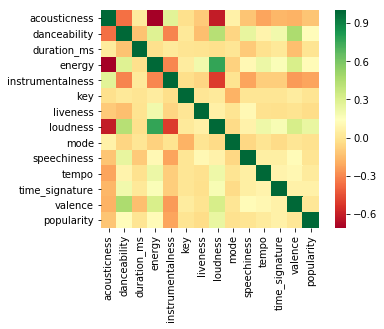

In [3]:
import seaborn as sns

sns.heatmap(spotify.corr(), square=True, cmap='RdYlGn')

Here's a rudimentary attempt at a linear regression model. This is just for practice and includes a few arbitrary columns.

In [5]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split

#pick a few independent variables, and set the dependent variable
X = spotify[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness']]
y = spotify.popularity

#fit and predict the model
lm = LinearRegression()
lm.fit(X,y)
lm.predict(X)[:2]

array([29.37066237, 26.99189831])

In [5]:
lm.score(X,y)

0.07074781553598763

The score for this model is pretty poor. Let's adjust the data and try again.

In [37]:
#re-run model for songs with pop greater than 0
over_zero = spotify[spotify['popularity'] > 0]
X = over_zero[['acousticness', 'danceability', 'energy', 'liveness', 'loudness', 'speechiness']]
y = over_zero.popularity

#fit and predict the model
lm = LinearRegression()
lm.fit(X,y)
prediction = lm.predict(X)
prediction[:2]

array([33.97605744, 31.54745617])

In [7]:
actual_pop = zip(y, prediction)
actual_100 = list(actual_pop)[:100]
actual_100[:3]

[(15, 33.97605743948594), (56, 31.547456165179973), (28, 34.11614314699749)]

In [9]:
diffs = {'Under 5': 0, '5 and 10': 0, 'Over ten': 0}
for pair in actual_100:
    if abs(pair[0] - pair[1]) < 5:
        diffs['Under 5'] += 1
    elif 5 <= abs(pair[0] - pair[1]) < 10:
        diffs['5 and 10'] += 1
    else:
        diffs['Over ten'] += 1
            
diffs

{'Under 5': 14, '5 and 10': 34, 'Over ten': 52}

The score is slightly improved

In [38]:
lm.score(X,y)

0.09051830632081626

### <b>pd.get_dummies</b>
<br>
Restructuring the model to account for categorical data.

In [22]:
#Set up the data for encoding: 'track_name' is categorical but is not useful so it will be dropped
encoded = so.drop('track_name', axis=1)

#Now, drop songs with popularity of zero as they create noise
encoded = encoded[encoded['popularity'] > 0]

encoded = pd.get_dummies(encoded)

In [10]:
encoded.shape

(111774, 29817)

In [57]:
%%time
encoded_samp = encoded.sample(n=20000, replace=True)

X = encoded_samp.drop('popularity', axis=1)
y = encoded_samp.popularity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm = LinearRegression()
lm.fit(X_train,y_train)

Wall time: 16min 13s


In [35]:
lm.score(X_test, y_test)

ValueError: shapes (33533,11) and (6,) not aligned: 11 (dim 1) != 6 (dim 0)

Predict over 10,000 rows and create custom measurement to assess model:

In [55]:
encoded_samp = encoded.sample(n=10000, replace=True)

X = encoded_samp.drop('popularity', axis=1)
y = encoded_samp.popularity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lin = LinearRegression()
lin.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [56]:
lin.score(X_test, y_test)

-2408713961.623535

In [57]:
prd = lin.predict(X_test)

In [58]:
def custom_loss(prediction, actual):
    paired = zip(prediction, actual)
    listed = list(paired)
    diffs = {'Under 5': 0, '5 and 10': 0, 'Over ten': 0}

    for pair in listed:
        if abs(pair[0] - pair[1]) < 5:
            diffs['Under 5'] += 1
        elif 5 <= abs(pair[0] - pair[1]) < 10:
            diffs['5 and 10'] += 1
        else:
            diffs['Over ten'] += 1
     
    return diffs

print(custom_loss(prd, y_test))

{'Under 5': 743, '5 and 10': 348, 'Over ten': 1909}


In [60]:
print(len(prd), len(y_test))

3000 3000


In [62]:
#percentages of encoded "successes"
x = (743 + 348) / 3000

x

0.3636666666666667

In [81]:
'''Retry model without the encoded categoricals'''
X = over_zero.drop(['artist_name', 'track_id', 'track_name', 'key', 'mode', 'time_signature', 'popularity'], axis=1)
y = over_zero.popularity

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lreg = LinearRegression()
lreg.fit(X_train,y_train)
pred = lreg.predict(X_test)

print(custom_loss(pred, y_test))

{'Under 5': 7044, '5 and 10': 6567, 'Over ten': 19922}


In [82]:
#X_test.columns

In [83]:
print(lreg.score(X_test, y_test))

0.10150833268129189


This model has a perfect score? That doesn't seem right.
<br>
Okay, nevermind. Once I removed the popularity info from the X variable, the results are more as expected. However, the results are improved over the large dataset with the encoded categorical data. Perhaps that's because the error is less amplified.

In [113]:
#Check which coefficients are best
coeffs = pd.concat([pd.DataFrame(X.columns), pd.DataFrame(lin.coef_)], axis=1)
coeffs.columns = ['Feature', 'Value']
coeffs = coeffs.sort_values('Value', ascending=False)
coeffs.reset_index(inplace=True)
coeffs.drop('index', axis=1).head()

,Feature,Value
0,artist_name_10cellphones,1.314179e+07
1,artist_name_1991,1.265387e+07
2,artist_name_.Sinh,1.255652e+07
3,artist_name_169,1.220318e+07
4,artist_name_10시 45분,1.212567e+07


Fit linear model over batches:

In [13]:
#batching
def batch_score(dt, size):
    scores = []
    for i in range(10):
        sample = dt.sample(n=size, replace=True)
    
        X = sample.drop('popularity', axis=1)
        y = sample.popularity
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
        reg = LinearRegression()
        reg.fit(X_train, y_train)
    
        scores.append(reg.score(X_test, y_test))
    return scores

print(np.median(batch_score(encoded, 10000)))

-13227041927.4118


<b>A basic ridge model without hyperparameter tuning:</b>

In [84]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X_r = encoded_samp.drop(['key', 'mode', 'time_signature', 'popularity'], axis=1)
y_r = encoded_samp.popularity

X_tr, X_ts, y_tr, y_ts = train_test_split(X_r, y_r, test_size=0.3, random_state=5)

ridge = Ridge(alpha = 0.5, normalize=True)
ridge.fit(X_tr, y_tr)

ridge.score(X_ts, y_ts)

0.37031368610273585

In [85]:
#Custom loss function results
pred_rdg = ridge.predict(X_ts)

print(custom_loss(pred_rdg, y_ts))

{'Under 5': 857, '5 and 10': 766, 'Over ten': 1377}


The ridge model above is definitely an imporvement over the basic linear model using the encoded data.

In [86]:
from sklearn.model_selection import cross_val_score

cv_res = cross_val_score(ridge, X_r, y_r, cv=5)
cv_res

array([0.33664579, 0.37208867, 0.36208081, 0.37075286, 0.3600336 ])

In [87]:
from sklearn.linear_model import Lasso

names = encoded_samp.drop(['key', 'mode', 'time_signature', 'popularity'], axis=1).columns

lasso = Lasso(alpha=0.1)

lasso_coefs = lasso.fit(X_r, y_r).coef_

coef_vals = list(zip(names, (list(lasso_coefs))))

print([pair for pair in coef_vals if abs(pair[1]) > 0])

[('danceability', 3.674463814521797), ('duration_ms', -5.283404880110184e-06), ('energy', -5.274845775246764), ('instrumentalness', -2.7622622706569127), ('liveness', -0.31321412831521195), ('loudness', 0.7647827269606422), ('tempo', 0.0005529130737982571), ('valence', -3.0495937539124607), ('artist_name_Armin van Buuren', -4.953100136536324), ('artist_name_Johann Sebastian Bach', -6.754373020036663), ('artist_name_Wolfgang Amadeus Mozart', -2.6045918012716758)]


In [88]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split(X_r, y_r, test_size=0.3, random_state=21)

lasso.fit(Xl_train, yl_train)
lasso.score(Xl_test, yl_test)

0.10004708870208734

In [89]:
lasso_pred = lasso.predict(Xl_test)
print(custom_loss(lasso_pred, yl_test))

{'Under 5': 625, '5 and 10': 586, 'Over ten': 1789}


The ridge regression model seems to perform better than the others.

## Popular songs to total songs ratio

Using a histogram and playing around with the binning parameter, I came across an interesting feature of the data: the frequency of song popularities seem to spike in intervals of 25. This is a curious characteristic worth exploring later, but for now I want to focus on the last spike around the 75 mark. I can use this group to explore what is popular, in this case anything with a score of at least 75, and find all artists with at least one song that fits that criteria.

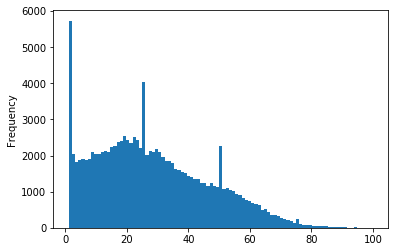

In [15]:
over_0 = so[so['popularity'] > 0]

_ = over_0['popularity'].plot(kind='hist', bins=95)

In [16]:
#Subset the data for only songs with popularity over 75 and count the number of tracks each artist had
#fitting this criteria. This will give a total count of 'popular' songs for each artist.
pop_artists = so[so['popularity'] > 75].groupby('artist_name').count().sort_values('track_name', ascending=False)
pop_artists = pop_artists.iloc[:,:1].sort_index()
pop_artists.columns = ['total_pop_tracks']
pop_artists.head(3)

,total_pop_tracks
artist_name,
(G)I-DLE,1
2 Chainz,3
21 Savage,4


Now, create a new dataframe with all the songs, not just the popular songs, from all the artists that have at least one popular song. This will allow us to compare the number of popular songs to the total number of songs.

In [17]:
x = list(pop_artists.index)

pop_full_catalog = pd.DataFrame()
for name in x:
    pop_full_catalog = pop_full_catalog.append(so[so['artist_name'] == name])
    
pop_full_catalog.head(3)

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
580,(G)I-DLE,Senorita,0.01590,0.782,197616,0.808,0.000042,0,0.331,-3.139,1,0.0362,120.021,4,0.420,78
1285,(G)I-DLE,LATATA,0.00427,0.774,202773,0.792,0.000001,9,0.283,-4.019,0,0.2240,98.100,4,0.505,73
1493,(G)I-DLE,HANN (Alone),0.05900,0.709,205820,0.718,0.000000,6,0.167,-3.315,0,0.0312,104.971,4,0.240,72


Count the total number of tracks for each popular artist.

In [18]:
pop_total_count = pop_full_catalog.groupby('artist_name').count().sort_values('track_name', ascending=False)
pop_total_count = pop_total_count.iloc[:,:1].sort_index()
pop_total_count.columns = ['total_tracks']
pop_total_count.head(3)

,total_tracks
artist_name,
(G)I-DLE,12
2 Chainz,23
21 Savage,16


Compute the ratio for popular tracks compared to total tracks. Create a new dataframe to show this info.

In [19]:
compare = pd.concat([pop_artists, pop_total_count], axis=1)
compare['popular_ratio'] = compare.total_pop_tracks / compare.total_tracks
compare = compare.sort_values('total_pop_tracks', ascending=False)
compare.head(10)

,total_pop_tracks,total_tracks,popular_ratio
artist_name,,,
Khalid,24,38,0.631579
Juice WRLD,23,44,0.522727
Ariana Grande,19,34,0.558824
Post Malone,18,30,0.600000
Billie Eilish,17,22,0.772727
Bad Bunny,14,23,0.608696
Ozuna,12,30,0.400000
6ix9ine,11,32,0.343750
XXXTENTACION,10,35,0.285714


In [20]:
compare.describe()

,total_pop_tracks,total_tracks,popular_ratio
count,375.000000,375.000000,375.000000
mean,2.285333,14.997333,0.281543
std,2.757813,12.868628,0.277016
min,1.000000,1.000000,0.017857
25%,1.000000,4.000000,0.085145
50%,1.000000,12.000000,0.172414
75%,3.000000,22.000000,0.338542
max,24.000000,75.000000,1.000000


In [21]:
compare[compare['total_pop_tracks'] == 1].sort_values('total_tracks', ascending=False)

,total_pop_tracks,total_tracks,popular_ratio
artist_name,,,
Mike Posner,1,56,0.017857
R3HAB,1,54,0.018519
EXO,1,43,0.023256
Wiz Khalifa,1,41,0.024390
TWICE,1,41,0.024390
Shoreline Mafia,1,40,0.025000
Gunna,1,40,0.025000
iKON,1,38,0.026316
"Tyler, The Creator",1,38,0.026316


<b>Observations:</b>
<br>
-Looking at the previous few cells, there seems to be a good bit of variability among total tracks for popular artists, ranging between 1 and 75. The ratio of popular tracks to total tracks also varies widely. <br>
-There are quite a few artists with a ratio of 100%. <br>
-The artist with the most popular tracks tend to have fairly high ratios, perhaps reinforcing the idea that the best indicator of creating a new hit song is to already have an old hit song.

<b>Plot the data to look for correlations.</b>

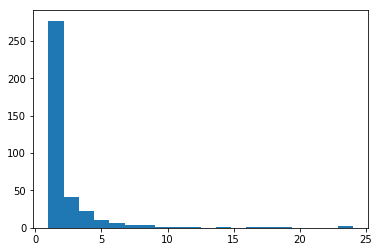

In [22]:
_ = plt.hist(compare.total_pop_tracks, bins=20)

Text(0, 0.5, 'Popular ratio')

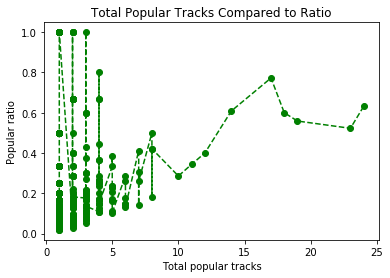

In [23]:
x = compare.total_pop_tracks
y = compare.popular_ratio

plt.plot(x, y, 'go--')
plt.title('Total Popular Tracks Compared to Ratio')
plt.xlabel('Total popular tracks')
plt.ylabel('Popular ratio')

Text(0, 0.5, 'Popular ratio')

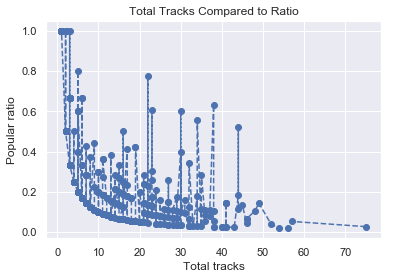

In [28]:
re_compare = compare.sort_values('total_tracks', ascending=False)
xx = re_compare.total_tracks
yy = re_compare.popular_ratio

plt.plot(xx, yy, 'bo--')
plt.title('Total Tracks Compared to Ratio')
plt.xlabel('Total tracks')
plt.ylabel('Popular ratio')

Comparing the charts above, having more total tracks tends to lead to a lower popular ratio, while those artists with more total popular songs tend to have a higher popular ratio despite having to put out more total tracks in order to score more 'hits'.

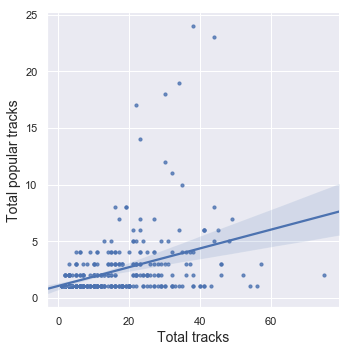

In [29]:
sns.set()
_ = sns.lmplot(x='total_tracks', y='total_pop_tracks', data=compare, scatter_kws={"s": 10})
_ = plt.xlabel('Total tracks', fontsize=14)
_ = plt.ylabel('Total popular tracks', fontsize=14)

### K-Means

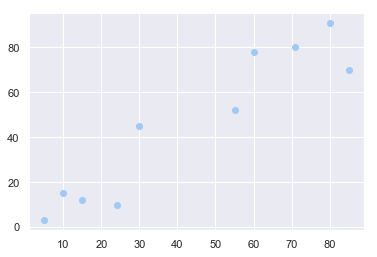

In [45]:
from sklearn.cluster import KMeans

X = np.array([[5,3],  
     [10,15],
     [15,12],
     [24,10],
     [30,45],
     [85,70],
     [71,80],
     [60,78],
     [55,52],
     [80,91],])

_ = plt.scatter(X[:,0],X[:,1], label='True Position')  

In [46]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
print(kmeans.cluster_centers_)

[[70.2 74.2]
 [16.8 17. ]]


In [47]:
kmeans.labels_

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

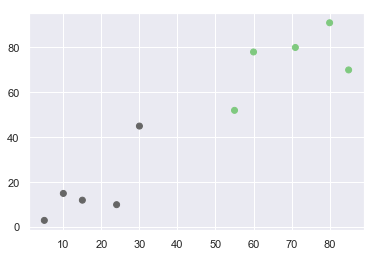

In [55]:
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='Accent')

Now try it with the popularity target variable with songs that have popularity over zero. Start with three clusters.

In [34]:
X = np.array(over_zero.popularity).reshape(-1,1)

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

kmeans.cluster_centers_

array([[11.12525362],
       [55.72517549],
       [31.40629944]])

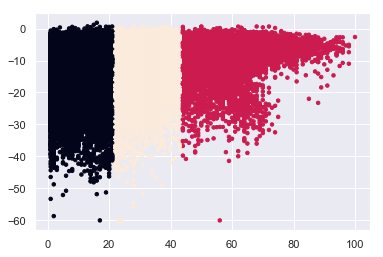

In [35]:
plt.scatter(X, over_zero.loudness, c=kmeans.labels_, s=12)

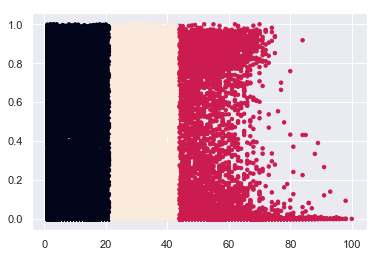

In [36]:
plt.scatter(X, over_zero.instrumentalness, c=kmeans.labels_, s=12)

Increasing the interations doesn't change anything.

In [39]:
X = np.array(over_zero.popularity).reshape(-1,1)

kmeans = KMeans(n_clusters=3, max_iter=600)
kmeans.fit(X)

kmeans.cluster_centers_

array([[55.72517549],
       [11.12525362],
       [31.40629944]])

Now try with more clusters to raise the bar for what qualifies as popular.

In [38]:
X = np.array(over_zero.popularity).reshape(-1,1)

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.cluster_centers_

array([[65.59952284],
       [19.06437498],
       [48.43151798],
       [ 6.20507582],
       [32.50901796]])

#### Explore the target column: popularity

In [ ]:
spotify['popularity'].describe()

In [21]:
#order the data by the target column; drop the track_id and superfluous index column
spotify_ordered = spotify.sort_values('popularity', ascending=False).reset_index()
so = spotify_ordered.drop(['index', 'track_id'], axis=1)

#start index at 1 to accurately see where popularities rank
so.index = so.index + 1
so.head(9)

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1,Daddy Yankee,Con Calma,0.1100,0.737,193227,0.860,0.000002,8,0.0574,-2.652,0,0.0593,93.989,4,0.656,100
2,Post Malone,Wow.,0.1630,0.833,149520,0.539,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,0.385,98
3,Billie Eilish,bad guy,0.3080,0.708,194088,0.418,0.093000,0,0.1000,-10.998,1,0.3680,131.926,4,0.578,98
4,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,0.5200,0.744,158040,0.494,0.000000,2,0.0716,-5.563,1,0.0699,89.972,4,0.927,98
5,Jonas Brothers,Sucker,0.0427,0.842,181040,0.734,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,0.952,98
6,Ariana Grande,"break up with your girlfriend, i'm bored",0.0421,0.726,190440,0.554,0.000000,5,0.1060,-5.290,0,0.0917,169.999,4,0.335,97
7,Sam Smith,Dancing With A Stranger (with Normani),0.4500,0.741,171030,0.520,0.000002,8,0.2220,-7.513,1,0.0656,102.998,4,0.347,96
8,Lady Gaga,Shallow,0.3710,0.572,215733,0.385,0.000000,7,0.2310,-6.362,1,0.0308,95.799,4,0.323,96
9,Ariana Grande,7 rings,0.5780,0.725,178640,0.321,0.000000,1,0.0884,-10.744,0,0.3230,70.142,4,0.319,96


We know that the median popularity score is 38. Let's see where other popularities fall on the scale.

In [ ]:
#how many songs equal the median popularity?
len(so[so['popularity'] == 38])

#What does this mean

What is the most frequent popularity score?

In [ ]:
so[['popularity']].mode()

In [ ]:
len(so[so['popularity'] == 0])

In [ ]:
#Where do songs with a 'middle' popularity score of 50 fall on the scale?
#There appears to be about 16k songs rated higher than 50
so[so['popularity'] == 50]

In [ ]:
so[so['popularity'] >= 90]

In [ ]:
so['popularity'].plot(kind='hist', bins=50)

In [ ]:
#find z-score for high popularity
pop = so['popularity']

z_of_90 = (90 - pop.mean()) / pop.std()
z_of_90

In [ ]:
low_pop = so[so['popularity'] <= 10]
len(low_pop)

In [ ]:
#percentage of songs with popularity at or below 10
(len(low_pop) / len(so)) * 100

The last few outputs demonstrate how rare songs are with high popularity ratings, and that a large portion of songs -- over 30% -- are virtually irrelevant. In fact, a score of 0 is by far the most frequent. 

This illustrates the problem that popularity may not have a formula. I need to find a way to come to terms with the fact that a large part of the equation comes down to marketing and cultural factors. It might be beneficial to drop all rows with a popularity rating of 0 because, even if they have the exact same characteristics as popular songs, they may simply not be popular due to factors outside the scope of this analysis.

#### Exploring and visualizing correlations

In [ ]:
#which artists occur the most?
so[['track_name', 'artist_name']].groupby('artist_name').count().sort_values('track_name', ascending=False)

Just some plot experiments below:

In [ ]:
so[so['popularity'] > 25].plot(kind='scatter', x='danceability', y='popularity', ylim=[15,100])

plt.show()

In [ ]:
so[so['popularity'] > 50].plot(kind='scatter', x='energy', y='popularity', ylim=[40,100], s=2)

plt.show()

In [ ]:
import seaborn as sns

sns.lmplot(x='energy', y='popularity', hue='mode', palette="Accent", scatter_kws={"s": 1}, data=so)
plt.show()

In [ ]:
above_70 = so[so['popularity'] > 70]

#compare with instrumentalness
sns.lmplot(x='instrumentalness', y='popularity', data=above_70, scatter_kws={"s": 10})

In [ ]:
#compare with liveness
sns.lmplot(x='liveness', y='popularity', data=above_70, scatter_kws={"s": 10})

In [ ]:
#compare with speechiness
sns.lmplot(x='speechiness', y='popularity', data=so, scatter_kws={"s": 1})

In [ ]:
#Attempt to make subplots: tempo vs. danceability
fig, axs = plt.subplots(ncols=2, sharex=False)
sns.regplot(x='tempo', y='popularity', data=above_70, scatter_kws={"s": 5}, ax=axs[0])
x = sns.regplot(x='danceability', y='popularity', data=above_70, scatter_kws={"s": 5}, ax=axs[1])
x.set(xlim=(0,1), ylim=(69,102))

Attemp at feature selection:

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
    
X_reg = so.iloc[:, [2,3,4,5,6,11,12]]
y_reg = so.loc[:, 'popularity']
X_new = SelectKBest(chi2, k=5).fit_transform(X_reg, y_reg)

pd.DataFrame(X_new)

#### Missing values

In [ ]:
so.info()

There appears to no null values, but for the sake of practice a few more tests are below:

In [ ]:
so.all()

In [ ]:
so.any()

In [ ]:
so[so.isnull()].count()

Now let's do some basic exploration of the dataset

In [ ]:
#What is the shape?
spotify.shape

In [ ]:
#Examine the first few rows
spotify.head()

In [ ]:
#Examine the tail
spotify.tail()

In [ ]:
#gather some basic statistical info
spotify.describe()

In [ ]:
#Narrow the focus to a couple key columns
spotify[['danceability', 'popularity']].describe()

We can see from above that, based on the mean and upper quartile range, the large majority of songs listed in the dataset have a low popularity rating. Considering that popular songs are often characterized as "Top 40" or "Billboard 100", this shouldn't really be a surprise.


Now let's a look at the metadata

In [ ]:
spotify.info()

Now we can sort the columns into two lists

In [ ]:
#Define a sorting function
def col_types(df):
    """A function to sort columns into two lists based on whether they are
    numeric or non-numeric"""
    num=[]
    non_num=[]
    for col in df:
        if np.dtype(df[col]) in (['int32', 'int64', 'float32', 'float64', 'complex64', 'long']):
            num.append(df.loc[:, col].name)
        else:
            non_num.append(df.loc[:, col].name)
    print('These columns are numeric: ' + str(num)) 
    print( '\nThese columns are non-numeric: ' + str(non_num))

In [ ]:
#run the function on the dataset
col_types(spotify)

## <b>json exercise playpen</b>

In [ ]:
projects = pd.read_json('data/world_bank_projects.json')

projects.columns

In [ ]:
projects = projects[['_id', 'approvalfy', 'country_namecode', 'countrycode', 'countryname', 'countryshortname', 'mjtheme', 'mjtheme_namecode', 'project_name']]

projects.shape

In [ ]:
grouped = projects[['countryshortname', 'project_name']].groupby('countryshortname').count()

#grouped.iloc[:10,:].sort_values('project_name', ascending=False)

ordered = grouped.sort_values('project_name', ascending=False)

top_10 = ordered.iloc[:10, :]

top_10

## <b>question 2</b> 

In [ ]:
projects.loc[491, 'mjtheme_namecode']

In [ ]:
themes = projects['mjtheme_namecode']

x = themes[1]

themes.head()

In [ ]:
counter = {}

for row in themes:
    for d in row:
        if d['code'] in counter:
            counter[d['code']] += 1
        else:
            counter[d['code']] = 1
            
counter

In [ ]:
import collections

count = collections.Counter()

for row in themes:
    for d in row:
        count[d['code']] += 1
        
count.most_common(10)

In [ ]:
import json
from pandas.io.json import json_normalize

x = pd.DataFrame()
#for row in themes:
#    x.append(json_normalize(row[0]))
    
x

In [ ]:
data = json.load(open('data/world_bank_projects.json'))

table = json_normalize(data, 'mjtheme_namecode', ['id'])

table.head(3)

In [ ]:
table[['name', 'code']].groupby('name').count().sort_values('code', ascending=False).head(10)

In [ ]:
table[['name', 'code']].groupby('code').count().sort_values('name', ascending=False).head(10)

### Question 3

In [ ]:
table.head(10)

In [ ]:
codes = list(table['code'])
names = list(table['name'])

zipped = list(zip(codes, names))
zipped = sorted(list(set(zipped)))

for tuple in zipped:
    if tuple[1] == '':
        zipped.remove(tuple)
    
zipped

In [ ]:
d = dict(zipped)
d

In [ ]:
for entry in themes:
    for theme in entry:
        if theme['name'] == '':
            theme['name'] = d[theme['code']]
            
type(themes)

In [ ]:
projects['mjtheme_namecode'] = themes
projects.loc[0, 'mjtheme_namecode']